# Check of the NOE quantitative reliability

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from functions import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams['figure.dpi'] = 300

In [2]:
pdb_ids = ['2LEA', '2K52', '2LTM', '2KD0', '2LF2']
pdb_id = pdb_ids[0]

## Reading the individual 3D $^{15}N$-NOESY peak lists

In [3]:
path = f'~/Sparky/Lists/{pdb_id}.list' # set correctly

# Reading the data
df = pd.read_csv(path, header=0, index_col=None, sep='\s+')
df = tidy_list(df)

# Why do we have negative NOEs? 
# Anyway, the phase is not important for this analysis, just remove the sign
df['height'] = np.abs(df.height)

df

,res,noe,N,Hn,H,height,noe_res,inter,resnum,noe_resnum,res_diff,atom_type,atom_type_pos
0,S1,H,116.240,8.111,8.111,1571,S1,False,1,1,0,H,H_i
1,S1,HA,116.240,8.111,4.389,1756,S1,False,1,1,0,HA,HA_i
2,S1,HB2,116.240,8.111,3.750,2457,S1,False,1,1,0,HB,HB_i
3,S1,HB3,116.240,8.111,3.750,2457,S1,False,1,1,0,HB,HB_i
4,S1,Y2H,116.240,8.111,8.062,554,Y2,True,1,2,-1,H,H_i+1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,S100,H99HB3,123.154,8.119,3.245,1350,S100,False,100,100,0,H,H_i
1790,S100,H,123.154,8.119,8.119,69967,S100,False,100,100,0,H,H_i
1791,S100,HA,123.154,8.119,4.258,2956,S100,False,100,100,0,HA,HA_i
1792,S100,HB2,123.154,8.119,3.849,3318,S100,False,100,100,0,HB,HB_i


Removing the side-chains

In [4]:
df = df.loc[~ (df.res.str.contains('ND') | df.res.str.contains('NE'))]

Remove the backbone-to-sidechain contacts (they are too intense or just overlapped)

In [5]:
df = df.loc[~ (df.noe.str.contains('HG') | df.noe.str.contains('HD') | df.noe.str.contains('HE'))]

Removing the diagonals

In [6]:
df = df.query('Hn != H')

In [7]:
df.shape

(1161, 13)

# Analysis

In [8]:
print(f"The protein we consider below  - PDB ID {pdb_id} - has {df.res.unique().shape[0]} assigned residues.")

The protein we consider below  - PDB ID 2LEA - has 91 assigned residues.


### Intensity distribution

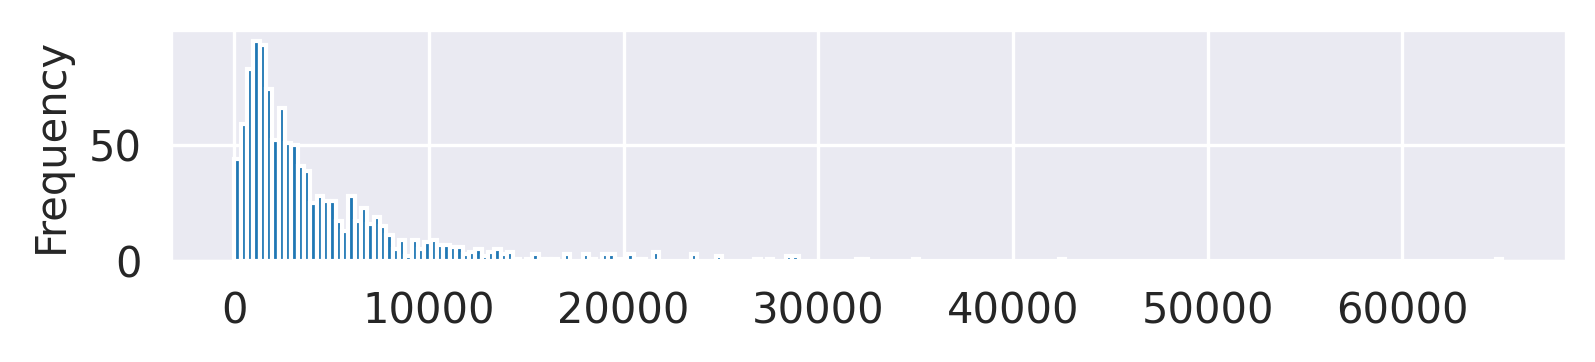

In [9]:
df.height.plot(kind='hist', figsize=(6,1), bins=200);

Simplifying the NOE contact categories: everything that's more than 1 residue away is now "far"

In [10]:
df.loc[df.res_diff.abs() > 1, "atom_type_pos"] = df.loc[df.res_diff.abs() > 1, "atom_type"] + "_far"

## Summary stats on NOE peak intensity

Converting the peak heights to relative across the spin system

In [11]:
df = convert_heights_to_relative(df)

## Frequency matrices

Total

In [12]:
get_noe_ranks(df, exclude_sc=False)

,1st highest,2nd highest,3rd highest,4th or lower
Atom name,,,,
HA_i,13,26,19,35
HA_i-1,35,14,10,31
H_i-1,4,4,4,71


Side-chain protons (here: only $H^\beta$ atoms remain in the dataset) often give rise to very intense peaks, due to those being equivalent protons or due to overlap with other NOEs from other spin systems. Let's exclude them and only consider the backbone atoms ($H^\alpha_i$, $H^\alpha_{i-1}$, $H_{i-1}$) for the calculation of the ranks:

In [13]:
get_noe_ranks(df, exclude_sc=True)

,1st highest,2nd highest,3rd highest,4th or lower
Atom name,,,,
HA_i,30,38,20,5
HA_i-1,41,14,10,25
H_i-1,7,15,18,43


Considering only alphatic protons ($H^\alpha_{i[-1]}$)

In [14]:
get_noe_ranks(df.query("atom_type == 'HA'"), exclude_sc=False)

,1st highest,2nd highest,3rd highest,4th or lower
Atom name,,,,
HA_i,43,34,14,2
HA_i-1,44,25,19,2


Considering only amide protons ($H_{i}$)

In [15]:
get_noe_ranks(df.query("atom_type == 'H'"), exclude_sc=False)

,1st highest,2nd highest,3rd highest,4th or lower
Atom name,,,,
H_i-1,44,29,6,4


In [16]:
df[['atom_type_pos', 'height']].groupby(['atom_type_pos']).mean().sort_values('height', ascending=False).head(20)

,height
atom_type_pos,
HA_i-1,0.715717
HB_i,0.646528
HA_i,0.626319
HB_i-1,0.445484
H_i,0.360898
H_i-1,0.353140
H_i+1,0.311996
HA_far,0.303104
HB_far,0.273503


***Minimum** relative* intensities of NOEs with respect to the spin system's maximum intensity

In [17]:
df[['atom_type_pos', 'height']].groupby(['atom_type_pos']).min().sort_values('height', ascending=False).head(20)

,height
atom_type_pos,
HA_i,0.134445
HA_i-1,0.121882
H_i,0.083110
HZ_far,0.036689
HB_i-1,0.036272
HA_i+1,0.022459
HB_far,0.020339
H_i+1,0.019677
H_i-1,0.019633


## Distributions

In [18]:
df_to_plot = df.loc[df['atom_type_pos'].isin(["H_i-1", "HA_i-1", "HA_i"])][['res', 'height', 'atom_type_pos']]

df_to_plot['atom_type_pos'] = df_to_plot['atom_type_pos'].replace(
    {'H_i-1': '$H_{i-1}$', 'HA_i-1': '$H^A_{i-1}$', 'HA_i': '$H^A_{i}$'})

df_to_plot.head()

,res,height,atom_type_pos
1,S1,0.714693,$H^A_{i}$
5,Y2,0.609692,$H_{i-1}$
6,Y2,1.000000,$H^A_{i-1}$
10,Y2,0.440941,$H^A_{i}$
16,G3,0.045911,$H_{i-1}$


/home/katja/PycharmProjects/NOESY_3D/.venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 16.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/katja/PycharmProjects/NOESY_3D/.venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


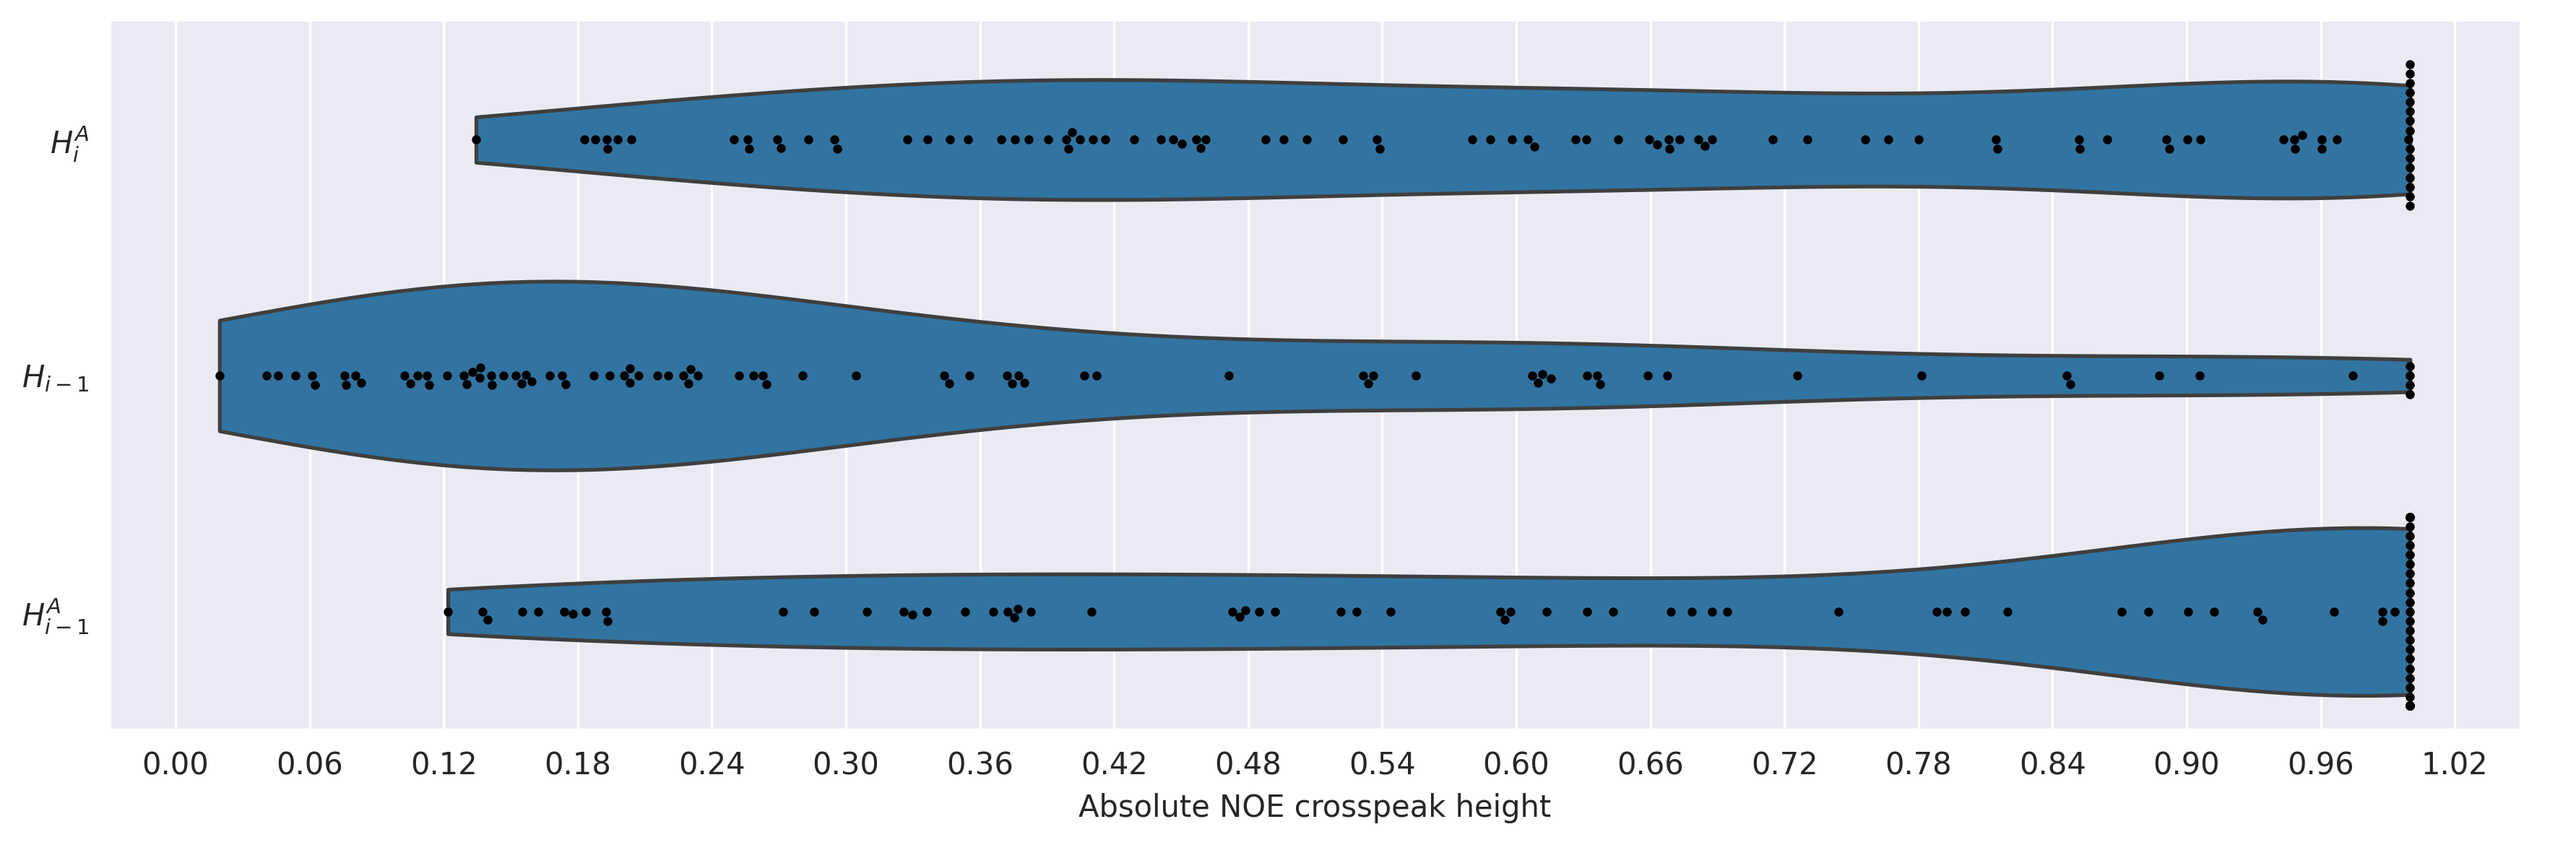

In [19]:
g = sns.catplot(data=df_to_plot, x="height", y="atom_type_pos", kind="violin", inner=None, aspect=3, height=4, cut=0)
sns.swarmplot(data=df_to_plot, x="height", y="atom_type_pos", color="k", size=3, ax=g.ax)
g.ax.xaxis.set_major_locator(plt.MaxNLocator(20))

plt.ylabel(None)
plt.xlabel("Absolute NOE crosspeak height");

Which crosspeaks are almost 0?

In [20]:
df_to_plot.loc[df_to_plot.height<1000].sort_values('height').head(7)

,res,height,atom_type_pos
1726,R90,0.019633,$H_{i-1}$
332,R23,0.040825,$H_{i-1}$
16,G3,0.045911,$H_{i-1}$
25,R4,0.053741,$H_{i-1}$
1628,V86,0.061169,$H_{i-1}$
1484,D80,0.062376,$H_{i-1}$
1752,G92,0.075472,$H_{i-1}$


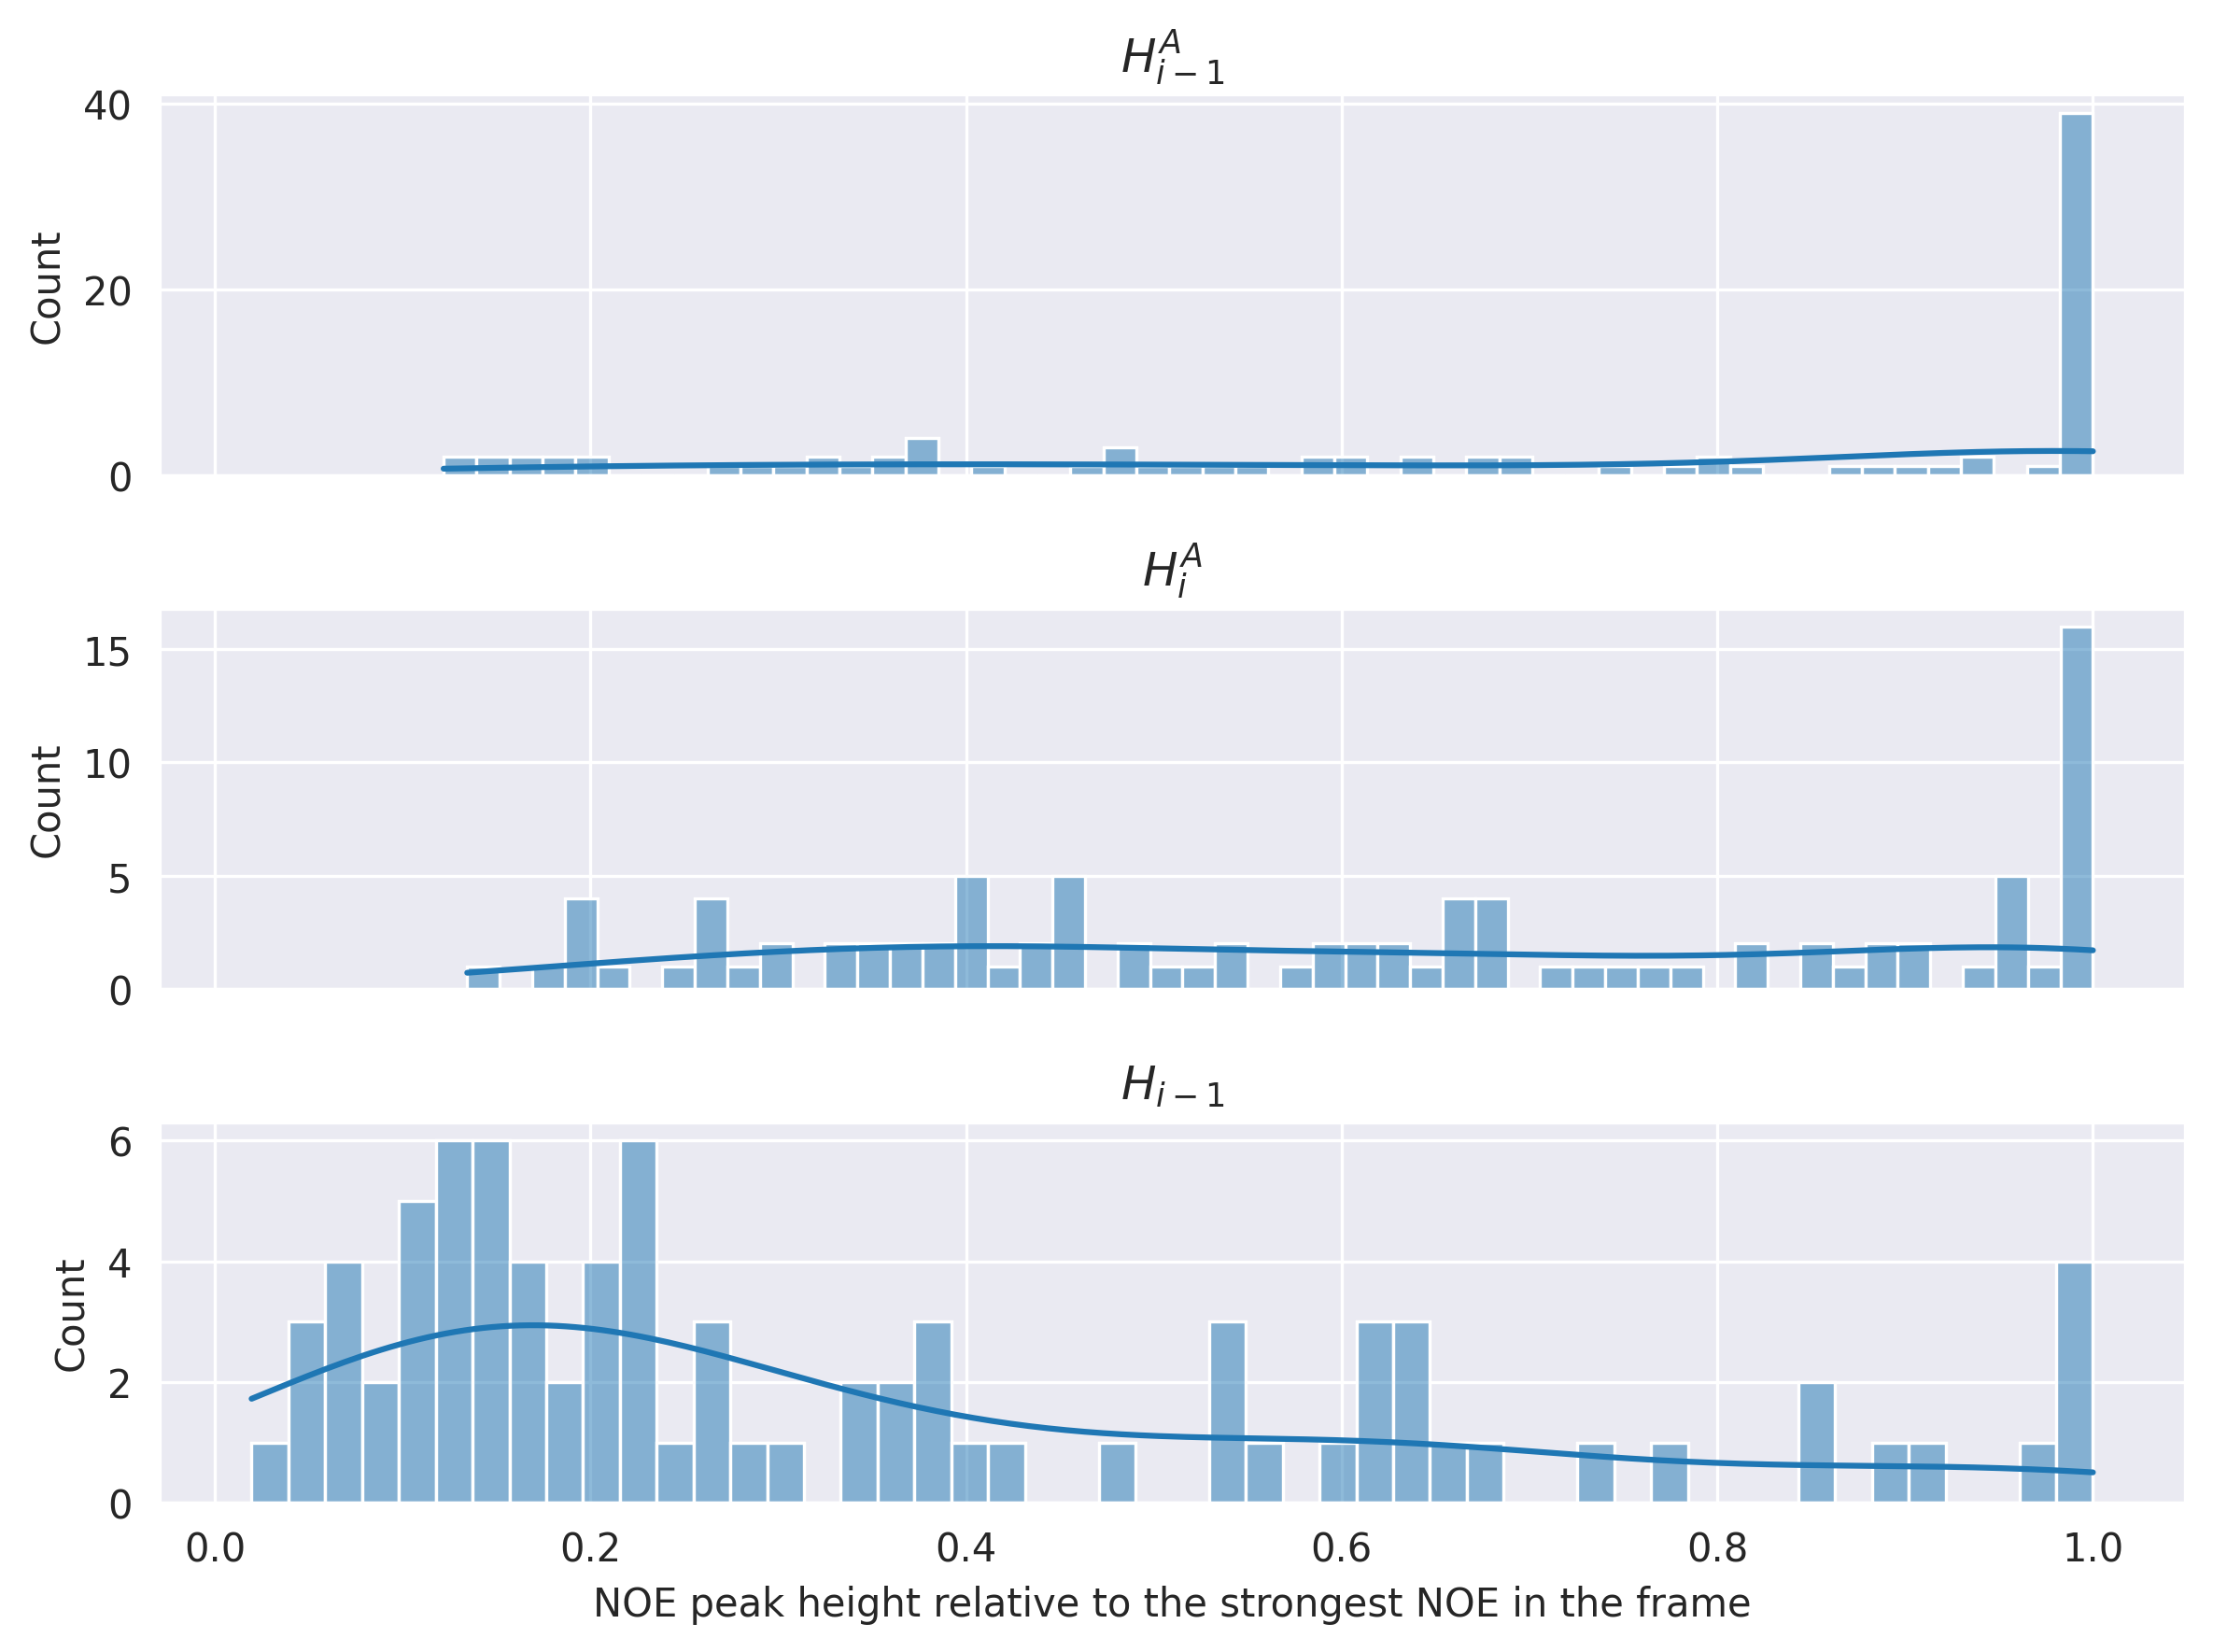

In [21]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,6), sharex=True)
df_groups = df_to_plot.groupby('atom_type_pos')

i=0
for gr, data in df_groups:
    sns.histplot(data=data, x="height", kde=True, bins=50, ax=axs[i])
    axs[i].set_title(gr)
    i+=1
    
plt.xlabel("NOE peak height relative to the strongest NOE in the frame")  
plt.tight_layout()